In [190]:
%run "rossmann_01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 25 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int32         
 1   day_of_week                   1017209 non-null  int8          
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int32         
 5   open                          1017209 non-null  int8          
 6   promo                         1017209 non-null  int8          
 7   state_holiday                 1017209 non-null  category      
 8   school_holiday                1017209 non-null  int8          
 9   store_type                    1017209 non-null  category      
 10  assortment                    1017209 non-null  category      
 11

In [169]:
### Data Analisy Libraries ###
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from datetime import datetime, time, date, timedelta
import json
import pickle
from sklearn.metrics       import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.ensemble      import RandomForestRegressor
#from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
#from boruta                import BorutaPy
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import TimeSeriesSplit
#from sklearn.model_selection import train_test_split
import xgboost as xgb
#from xgboost import plot_importance
from xgboost import XGBRegressor
import time

from flask import Flask, request, Response
import requests

import scipy.stats as stats
from scipy.stats import norm

### Content

* **Data Preparation**
    - Normalization
    - Standardization
    - Encoding
    - Feature Selection
    - Dealing with Outliers
* **Holdout**
    - Random Forest Regressor
    - XGBoost Regressor
* **Cross Validation**
    - Random Forest Regressor
    - XGBoost Regressor
* **Feature Selection**
    - Filter Method
    - Embeeded Method
    - Wrapper Method
    
* **Hiperparmters Tunning**
* **Dump Model**


# Data Preparation

In [170]:
data_prep = data.copy()
data_prep.tail()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,promo2_since_week,promo2_since_year,promo_interval,day,month,year,day_of_year,competition_open_since,promo_open_since,is_promo_month
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,...,31,2013,"Jan,Apr,Jul,Oct",1,1,2013,1,0,0,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,...,0,0,0,1,1,2013,1,81,24156,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,...,0,0,0,1,1,2013,1,29,24156,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,...,0,0,0,1,1,2013,1,29,24156,0
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,...,22,2012,"Mar,Jun,Sept,Dec",1,1,2013,1,29,6,0


In [171]:
data_prep=data_prep.loc[(data_prep['sales']>0) & (data_prep['open'] ==1)].copy()

In [172]:
data_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017190
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844338 non-null  int32         
 1   day_of_week                   844338 non-null  int8          
 2   date                          844338 non-null  datetime64[ns]
 3   sales                         844338 non-null  int64         
 4   customers                     844338 non-null  int32         
 5   open                          844338 non-null  int8          
 6   promo                         844338 non-null  int8          
 7   state_holiday                 844338 non-null  category      
 8   school_holiday                844338 non-null  int8          
 9   store_type                    844338 non-null  category      
 10  assortment                    844338 non-null  category      
 11  competition_

C:\Users\Alysson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Alysson\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


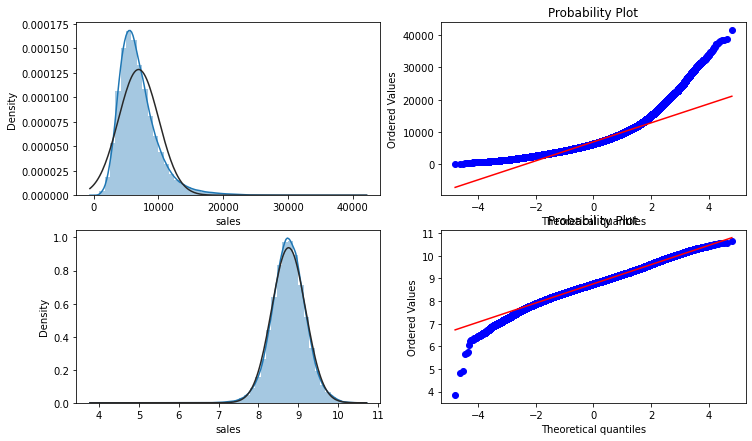

In [173]:
plt.figure(figsize=(12,7))
plt.subplot( 2, 2, 1)
sns.distplot(data_prep['sales'], fit=norm);
plt.subplot( 2, 2, 2)
stats.probplot(data_prep['sales'], plot=plt);
plt.subplot( 2, 2, 3)
sns.distplot(np.log1p(data_prep['sales']), fit=norm);
plt.subplot( 2, 2, 4)
stats.probplot(np.log1p(data_prep['sales']), plot=plt);

In [188]:
data_prep['sales'] = np.log1p(data['sales'])

In [189]:
assortment_dict = {'a': 1,  'b': 2, 'c': 3}
data_prep['assortment'] = data_prep['assortment'].map(assortment_dict)

store_dict = {'c': 1,  'd': 2, 'a': 3, 'b':4}
data_prep['store_type'] = data_prep['store_type'].map(store_dict) 

#promo_dict = {'0': 0,  'Jan,Apr,Jul,Oct': 1, 'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec':3}
#data['promo_interval'] = data['promo_interval'].map(promo_dict)        

data_prep['promo_interval'].replace("Mar,Jun,Sept,Dec", 3, inplace=True)
data_prep['promo_interval'].replace("Feb,May,Aug,Nov", 2, inplace=True)
data_prep['promo_interval'].replace("Jan,Apr,Jul,Oct", 1, inplace=True)
data_prep['promo_interval'].replace("0", 0, inplace=True)

data_prep['state_holiday'].replace("a", 1, inplace=True)
data_prep['state_holiday'].replace("b", 1, inplace=True)
data_prep['state_holiday'].replace("c", 1, inplace=True)
data_prep['state_holiday'].replace("0", 0, inplace=True)  




data_prep = data_prep.astype({"state_holiday": 'int8', 
                    "school_holiday": 'int8', 
                    "store_type": 'int8',
                    "assortment": 'int8'}) 

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [176]:
default_features = ['store',
                     'day_of_week',
                     'day',
                     'month',
                     'year',
                     'day_of_year',
                     'competition_distance',
                     'competition_open_since',
                     'promo',
                     #'is_promo_month',
                     'promo2',
                     #'competition_open_since_month', # Equivalent with competition_open_since
                     #'competition_open_since_year', # Equivalent with competition_open_since
                     'promo2_since_week',
                     'school_holiday', 
                     'promo_interval',
                     #'open',                 
                     'assortment',
                     'store_type'
                    ]
target = 'sales' 

feat_to_add = ['date', 'sales']
#Drop Features: customers,'date','open'

all_features = default_features.copy()
all_features = default_features.extend(feat_to_add)

In [178]:
train = data_prep.loc[data_prep['date'] < '2015-06-19']
test = data_prep.loc[data_prep['date'] >= '2015-06-19']

y_train = train[target]
X_train = train[default_features]#default_features, ts_features

y_test = test[target]
X_test = test[default_features]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

KeyError: "['d', 'a', 't', 'e', 's', 'l'] not in index"

## Holdout

In [74]:
def ml_error(y, yhat, model_name=False):
    r2 = r2_score(y, yhat)
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    mpe = np.mean((y-yhat)/y)
    rmpse  = np.sqrt(np.mean((yhat/y-1)**2)) 
    
    return pd.DataFrame( { 'Model' : model_name,
                           'R²': r2,
                           'MAE': mae, 
                           'MAPE': mape,
                           'MPE' : mpe,
                           'RMSE': rmse,
                           'RMPSE': rmpse}, index=[0] )

### Random Forest Regressor

In [34]:
%%time
np.random.seed(7)

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
#rf_results = ml_error( np.expm1(y_test), np.expm1(y_pred), "Random Forest")
#rf_results

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
rmpse = np.sqrt(np.mean((y_test/y_pred-1) ** 2))
    
print("Random Forest Regressor - Holdout")
print(f"RMSE:{rmse}")
print(f"RMPSE:{rmpse}") 

Random Forest Regressor - Holdout
RMSE:1031.1771637902718
RMPSE:0.015349177142848355
Wall time: 14min 13s


### XGBoost Regressor

In [76]:
%%time
np.random.seed(7)

xgb = XGBRegressor(objective='reg:squarederror')
xgb.fit(X_train, y_train)
y_pred=xgb.predict(X_test)

xgb_result = ml_error(np.expm1(y_test), np.expm1( y_pred))
#xgb_result = ml_error(y_test, y_pred)
#xgb_result

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
rmpse = np.sqrt(np.mean((np.expm1(y_test)/np.expm1(y_pred)-1) ** 2))
    
print("XGBoost - Holdout")
print(f"RMSE:{rmse}")
print(f"RMPSE:{rmpse}") 

XGBoost - Holdout
RMSE:1314.1661285067667
RMPSE:0.1788675692436151
Wall time: 9.46 s


## Hiperparamters Tunning

In [ ]:
%%time
#Tunning Parameters: XGBoost Regressor
np.random.seed(7)

params = {
   'n_estimators': [2500],
   'eta': [0.01, 0.03],
   'max_depth': [ 5, 9],
   'subsample': [0.1, 0.5],
   'min_child_weight': [3, 8]}

gs = GridSearchCV(xgb, params, cv=3, scoring='neg_mean_absolute_error',verbose=100, return_train_score=False)
gs.fit(X_train,y_train)

xgb_tuning_score = gs.best_score_

print(f"\nPrecision Best Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}") 

Fitting 3 folds for each of 32 candidates, totalling 96 fits


### Tunned Model

In [80]:
np.random.seed(7)

preds = []
scores = []

model_xgb_tuned = XGBRegressor( objective='reg:squarederror', n_estimators =2500, max_depth=5, min_child_weight=3, colsample_bytree=0.7)



model_xgb_tuned.fit(X_train, y_train)
y_pred=model_xgb_tuned.predict(X_test)
preds.append(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)
scores
#xgb_result = ml_error( np.expm1( y_test), np.expm1( y_pred))
#xgb_result = ml_error( y_test, y_pred)
#xgb_result

[0.1254008406434026]

In [82]:
xgb_tunned_result = ml_error( np.expm1( y_test), np.expm1( y_pred))
#xgb_result = ml_error( y_test, y_pred)
xgb_tunned_result

,Model,R²,MAE,MAPE,MPE,RMSE,RMPSE
0,False,0.899903,653.519277,0.093555,0.024848,963.067092,0.124307


In [84]:
pickle.dump( model_xgb_tuned, open( 'C:\\Users\\Alysson\\Documents\\Projects\\Rossmann-Sales-Forecast\\model\\model_xgb_tunned.pkl', 'wb' ))

## Feature Importance

### Filter Method


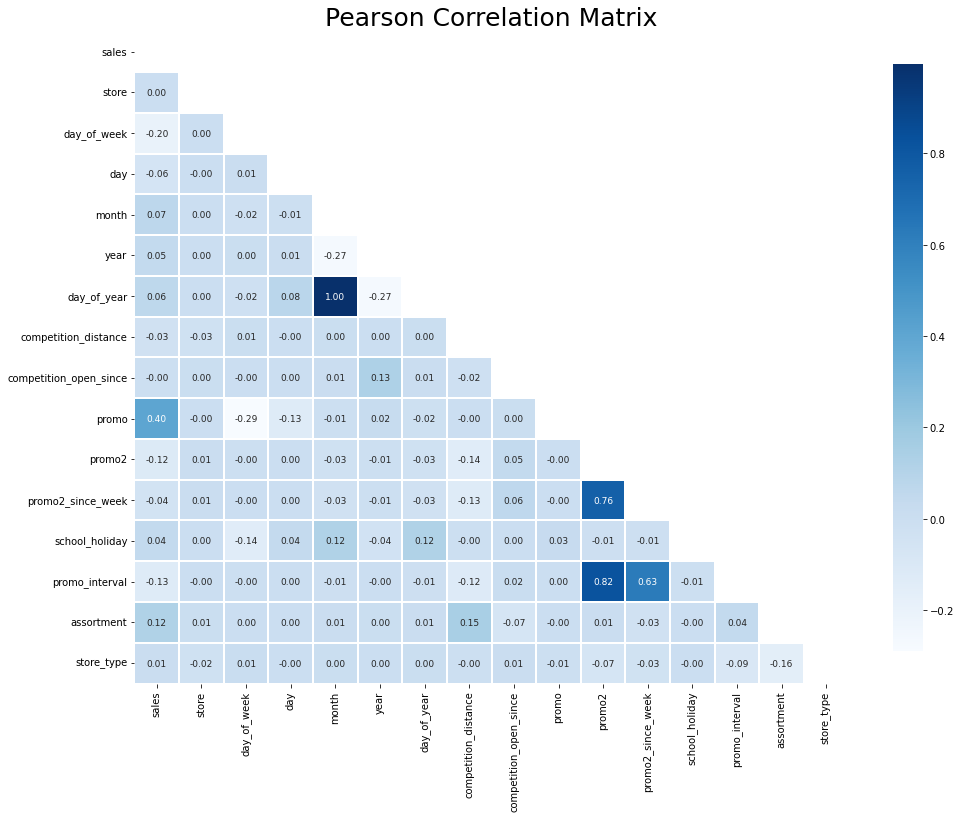

In [77]:
features = ['sales','store',
                     'day_of_week',
                     'day',
                     'month',
                     'year',
                     'day_of_year',
                     'competition_distance',
                     'competition_open_since',
                     'promo',
                     #'is_promo_month',
                     'promo2',
                     #'competition_open_since_month', # Equivalent with competition_open_since
                     #'competition_open_since_year', # Equivalent with competition_open_since
                     'promo2_since_week',
                     'school_holiday', 
                     'promo_interval',
                     #'open',                 
                     'assortment',
                     'store_type']


mask = np.zeros_like(data_prep[features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data_prep[features].corr(),linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [78]:
data_prep[features].corr()['sales'].abs().sort_values(ascending = False)

sales                     1.000000
promo                     0.404686
day_of_week               0.195406
promo_interval            0.125037
assortment                0.121871
promo2                    0.116682
month                     0.069149
day_of_year               0.063608
day                       0.059281
year                      0.046564
school_holiday            0.044255
promo2_since_week         0.043664
competition_distance      0.031476
store_type                0.010545
competition_open_since    0.004777
store                     0.001163
Name: sales, dtype: float64

### Embeeded Method

In [32]:
fi_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

fi_xgb.head(10)

ValueError: All arrays must be of the same length

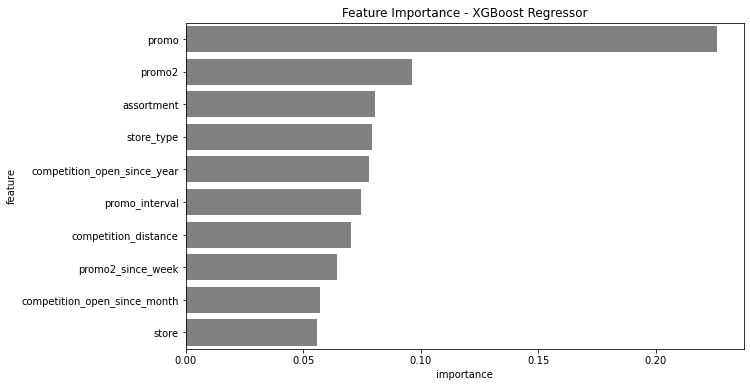

In [33]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance - XGBoost Regressor')
sns.barplot(data=fi_xgb.head(10), x='importance', y='feature', color='gray');

In [35]:
fi_rf = pd.DataFrame({
    'features': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

fi_rf.head(10)

,feature,importance
6,competition_distance,0.244263
0,store,0.188045
8,promo,0.162200
7,competition_open_since,0.085743
1,day_of_week,0.065038
14,store_type,0.052563
5,day_of_year,0.051468
10,promo2_since_week,0.046652
2,day,0.037152
12,promo_interval,0.022482


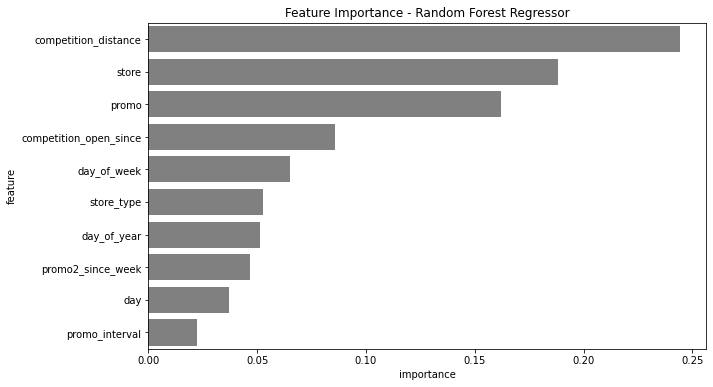

In [36]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance - Random Forest Regressor')
sns.barplot(data=fi_rf.head(10), x='importance', y='features', color='gray');

In [85]:
df9 = X_test[default_features]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

KeyError: 'sales'

In [118]:
df10 = pd.read_csv( '../data/raw/test.csv' )

In [119]:
# merge test dataset + store
df_test = pd.merge( df10, data_store_raw, how='left', on='Store' )

# choose store for prediction
#df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [120]:
df_test=df_test.sample(5)

In [121]:
df_json = json.dumps( df_test.to_dict( orient='records' ) )

In [122]:
url = 'http://127.0.0.1:5000/rossmann/predict'

#url = 'https://winequalitytest123.herokuapp.com/predict'
header = {'Content-type': 'application/json'}
r = requests.post(url=url, data=df_json, headers=header)
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [123]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [124]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 238 will sell R$9411.7939453125 in the next 6 weeks
Store Number 284 will sell R$11543.294921875 in the next 6 weeks
Store Number 331 will sell R$6018.1171875 in the next 6 weeks
Store Number 1005 will sell R$11160.89453125 in the next 6 weeks
Store Number 1113 will sell R$4539.6435546875 in the next 6 weeks


In [186]:
all_features = default_features.copy()
all_features = default_features.extend(feat_to_add)

In [187]:
df9 = X_test[all_features]

df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( y_pred)

KeyError: None

In [165]:
df9

,store,day_of_week,day,month,year,day_of_year,competition_distance,competition_open_since,promo,promo2,promo2_since_week,school_holiday,promo_interval,assortment,store_type
0,1,5,31,7,2015,212,1270,82,1,0,0,1,0,1,1
1,2,5,31,7,2015,212,570,92,1,1,13,1,1,1,3
2,3,5,31,7,2015,212,14130,103,1,1,14,1,1,1,3
3,4,5,31,7,2015,212,620,70,1,0,0,1,0,3,1
4,5,5,31,7,2015,212,29910,3,1,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47940,1111,5,19,6,2015,170,1900,12,1,1,31,0,1,1,3
47941,1112,5,19,6,2015,170,1880,110,1,0,0,0,0,3,1
47942,1113,5,19,6,2015,170,9260,58,1,0,0,0,0,3,3
47943,1114,5,19,6,2015,170,870,58,1,0,0,0,0,3,3


In [ ]:
cols_selected_boruta_full.extend( feat_to_add )

In [130]:
# rescale

df9['sales'] = np.expm1( y_test['sales'] )
#df9['predictions'] = np.expm1( yhat_xgb_tuned )

KeyError: 'sales'

In [131]:
df9

,store,day_of_week,day,month,year,day_of_year,competition_distance,competition_open_since,promo,promo2,promo2_since_week,school_holiday,promo_interval,assortment,store_type
0,1,5,31,7,2015,212,1270,82,1,0,0,1,0,1,1
1,2,5,31,7,2015,212,570,92,1,1,13,1,1,1,3
2,3,5,31,7,2015,212,14130,103,1,1,14,1,1,1,3
3,4,5,31,7,2015,212,620,70,1,0,0,1,0,3,1
4,5,5,31,7,2015,212,29910,3,1,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47940,1111,5,19,6,2015,170,1900,12,1,1,31,0,1,1,3
47941,1112,5,19,6,2015,170,1880,110,1,0,0,0,0,3,1
47942,1113,5,19,6,2015,170,9260,58,1,0,0,0,0,3,3
47943,1114,5,19,6,2015,170,870,58,1,0,0,0,0,3,3
